## 1. importing neccessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import missingno as msno
from pandas.plotting import lag_plot

# Configurations
pd.set_option('display.max_columns', 50)
plt.style.use("seaborn-v0_8")
sns.set_palette("viridis")

# Load data
df = pd.read_csv('D:\DS-Intern-Assignment\data\data.csv', parse_dates=['timestamp'])
print(f"Data Shape: {df.shape}")
df.head()

Data Shape: (16857, 29)


,timestamp,equipment_energy_consumption,lighting_energy,zone1_temperature,zone1_humidity,zone2_temperature,zone2_humidity,zone3_temperature,zone3_humidity,zone4_temperature,zone4_humidity,zone5_temperature,zone5_humidity,zone6_temperature,zone6_humidity,zone7_temperature,zone7_humidity,zone8_temperature,zone8_humidity,zone9_temperature,zone9_humidity,outdoor_temperature,atmospheric_pressure,outdoor_humidity,wind_speed,visibility_index,dew_point,random_variable1,random_variable2
0,2016-01-11 17:00:00,60.0,-77.78778596503064,33.74660933896648,47.59666666666671,19.2,44.790000,19.79,NaN,19.000000,45.566667,17.166667,55.20,NaN,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.300000,13.275433,13.275433
1,2016-01-11 17:10:00,60.0,30.0,19.89,46.69333333333329,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,NaN,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.200000,18.606195,18.606195
2,2016-01-11 17:20:00,50.0,30.0,19.89,46.3,19.2,44.626667,19.79,44.933333,35.921144,45.890000,NaN,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.100000,28.642668,28.642668
3,2016-01-11 17:30:00,50.0,40.0,33.74660933896648,46.0666666666667,19.2,44.590000,19.79,45.000000,NaN,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,94.385668,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,37.673716,45.410389,45.410389
4,2016-01-11 17:40:00,60.0,40.0,19.89,46.33333333333329,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,4.476511,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.900000,10.084097,10.084097


## 2. Getting High level overvview of data
- We can see some columns have incorrect data type eg. timestamp, equipment_energy_consumtion, lightning_energy..etc
- we can see there are negative values in humidity, visibility_index, wind_speed which is not possible
- we can observe that there are a lot of outliers present in our data

In [267]:
# Missing values
print("\n Missing Values Analysis")
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_percentage
})
print(missing_df[missing_df['Missing Values'] > 0])

# Duplicates
print(f"\nDuplicate Rows: {df.duplicated().sum()}")

# statistical summary of dataset
print("\n 1.4 statistical summary of data")
print(df.describe().T)

# Data types
print("\nData Types:\n", df.dtypes)


 Missing Values Analysis
                              Missing Values  Percentage (%)
equipment_energy_consumption             844        5.006822
lighting_energy                          809        4.799193
zone1_temperature                        867        5.143264
zone1_humidity                           801        4.751735
zone2_temperature                        853        5.060212
zone2_humidity                           867        5.143264
zone3_temperature                        802        4.757667
zone3_humidity                           878        5.208519
zone4_temperature                        816        4.840719
zone4_humidity                           781        4.633090
zone5_temperature                        838        4.971229
zone5_humidity                           801        4.751735
zone6_temperature                        848        5.030551
zone6_humidity                           847        5.024619
zone7_temperature                        794        4.71020

### 2.1 FIxing data error
- converting timestamp column from object to time
- converting numerical col from object to numeric
- replacing the impossible values with NaN value
- printing missing %
-  we can see almost 4-5% missing values are present in every column

In [270]:
print("\n converting Timestamp to DateTime")
# converting the timestamp column to datatime as it is object
if 'timestamp' in df.columns:
    if not pd.api.types.is_datetime64_any_dtype(df['timestamp']):
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    print("Timestamp converted to datetime format")
    

# fixing numeric columns stored as objects
object_cols = [
    'equipment_energy_consumption',
    'lighting_energy',
    'zone1_temperature',
    'zone1_humidity',
    'zone2_temperature'
]

for col in object_cols:
    # if there is any characters first we are replacing it with empty
    df[col] = df[col].str.replace('[^\d.]', '', regex=True)
    # then convert to float
    df[col] = pd.to_numeric(df[col], errors='coerce')

print("\n Data shape:")
print(df.shape)


# Define the function to replace negative values with NaN
def set_negative_to_nan(series):
    return series.where(series >= 0, np.nan)

# Columns where negative values are invalid
columns_to_clean = [col for col in df.columns if 'humidity' in col.lower()] + ['wind_speed', 'visibility_index']

# Apply the function to these columns
df[columns_to_clean] = df[columns_to_clean].apply(set_negative_to_nan)


# Missing values
print("\n Missing Values Analysis")
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_percentage
})
print(missing_df[missing_df['Missing Values'] > 0])

<>:20: SyntaxWarning: invalid escape sequence '\d'
<>:20: SyntaxWarning: invalid escape sequence '\d'
C:\Users\knj93\AppData\Local\Temp\ipykernel_11620\3362448333.py:20: SyntaxWarning: invalid escape sequence '\d'
  df[col] = df[col].str.replace('[^\d.]', '', regex=True)



 converting Timestamp to DateTime
Timestamp converted to datetime format

 Data shape:
(16857, 29)

 Missing Values Analysis
                              Missing Values  Percentage (%)
equipment_energy_consumption             912        5.410215
lighting_energy                          864        5.125467
zone1_temperature                        949        5.629709
zone1_humidity                           888        5.267841
zone2_temperature                        923        5.475470
zone2_humidity                          1011        5.997508
zone3_temperature                        802        4.757667
zone3_humidity                          1065        6.317850
zone4_temperature                        816        4.840719
zone4_humidity                          1121        6.650056
zone5_temperature                        838        4.971229
zone5_humidity                          1102        6.537344
zone6_temperature                        848        5.030551
zone6_humidity      

### 3. Outlier detection
- our observation was right there is a lot of outliers present in the data
- around 14% outliers are present in visibility_index, 12% in target col, 7% in zone5_humidity and so on

In [275]:
print("\n Outlier Detection")
# function to detect outliers using IQR method
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers.shape[0], lower_bound, upper_bound

# Checking outliers in key numerical columns
numerical_columns = df.select_dtypes(include=np.number).columns.tolist()
outlier_summary = []

for column in numerical_columns:
    n_outliers, lower, upper = detect_outliers(df, column)
    percentage = (n_outliers / len(df)) * 100
    outlier_summary.append({
        'Column': column,
        'Outliers Count': n_outliers,
        'Percentage (%)': percentage,
        'Lower Bound': lower,
        'Upper Bound': upper
    })

outlier_df = pd.DataFrame(outlier_summary)
print(outlier_df.sort_values('Percentage (%)', ascending=False).head(10))



 Outlier Detection
                          Column  Outliers Count  Percentage (%)  Lower Bound  \
24              visibility_index            2352       13.952661    12.500000   
0   equipment_energy_consumption            2055       12.190781   -25.000000   
11                zone5_humidity            1203        7.136501    32.750000   
1                lighting_energy             915        5.428012   -15.000000   
2              zone1_temperature             633        3.755117    18.100000   
8              zone4_temperature             574        3.405114    16.131667   
4              zone2_temperature             572        3.393249    15.315000   
12             zone6_temperature             493        2.924601    -7.210000   
5                 zone2_humidity             492        2.918669    30.087187   
21          atmospheric_pressure             458        2.716972   733.850000   

    Upper Bound  
24    56.500000  
0    175.000000  
11    66.750000  
1     25.000000 

### 4. Analysis of Target column
- we can see target column in highly skewed
- it has skewness 4+
- kurtosis 18+
- The ACF shows significant positive autocorrelation up to lag 10+
- This suggests that the energy consumption is strongly dependent on its past values there is a long memory effect.
- Lag plot shows some clustering along a diagonal, especially in the bottom-left region. This means there's some autocorrelation
- peak hour is from 8-14 and 16-20


 Target Variable Distribution


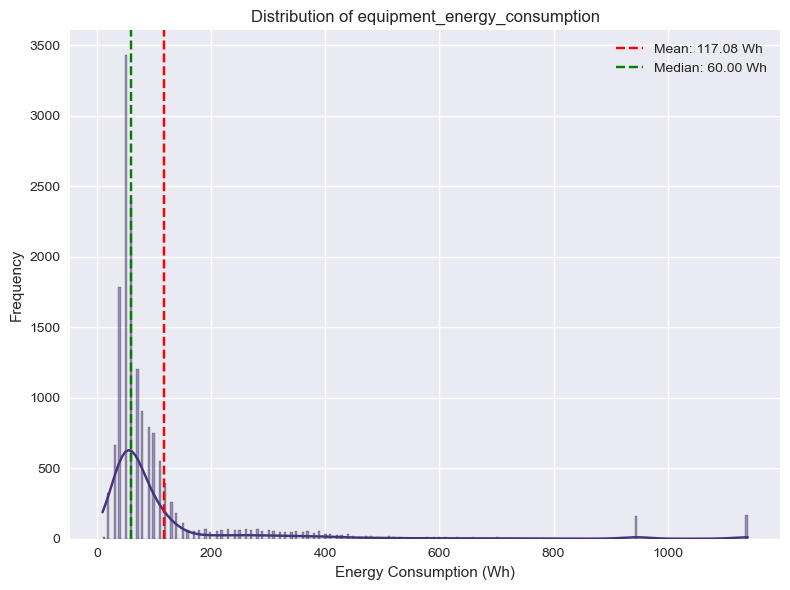

--------------------------------------------------

Skewness: 4.0852
Kurtosis: 18.4403
--------------------------------------------------

 Autocorrelation Analysis


<Figure size 800x600 with 0 Axes>

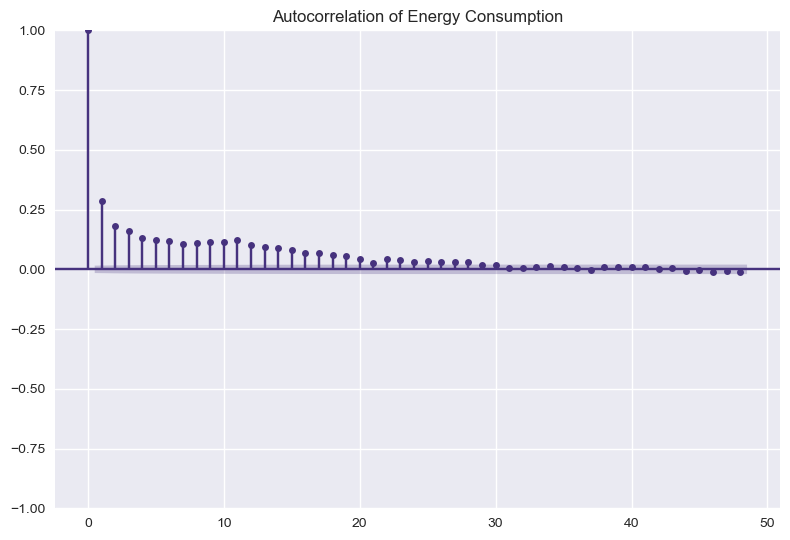

<Figure size 800x600 with 0 Axes>

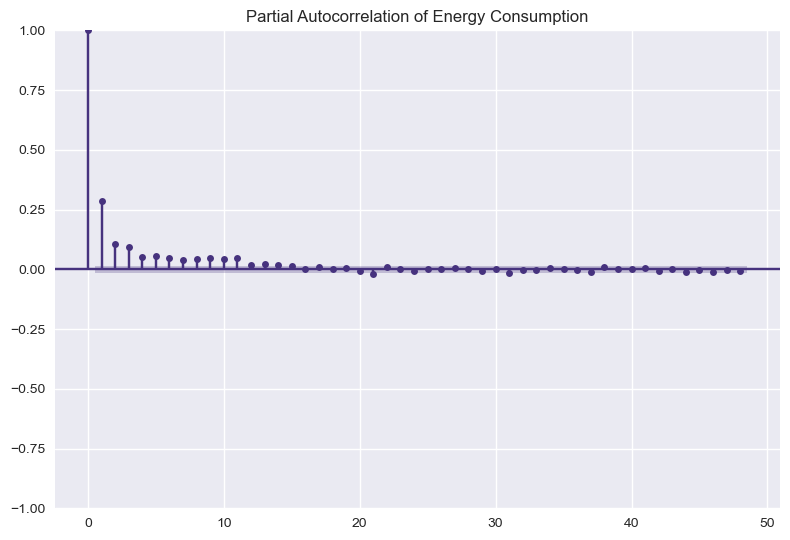

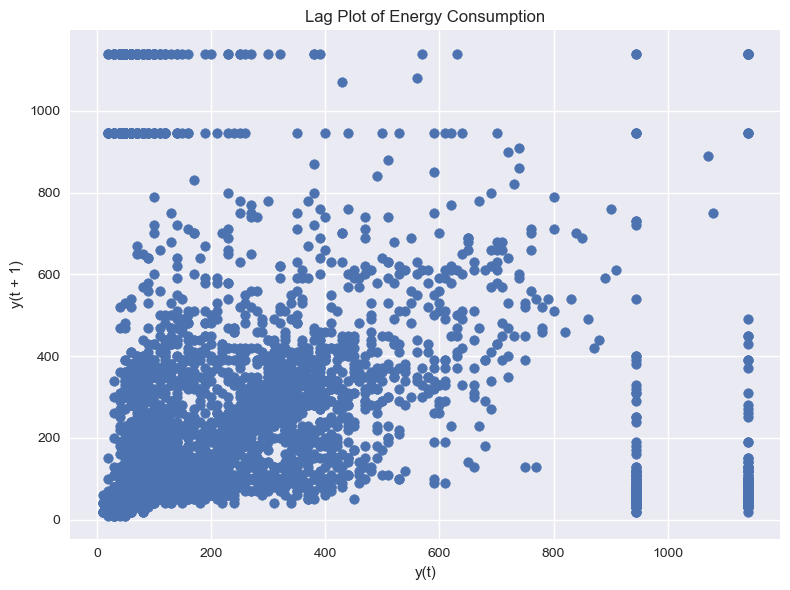


  Target Variable Over Time


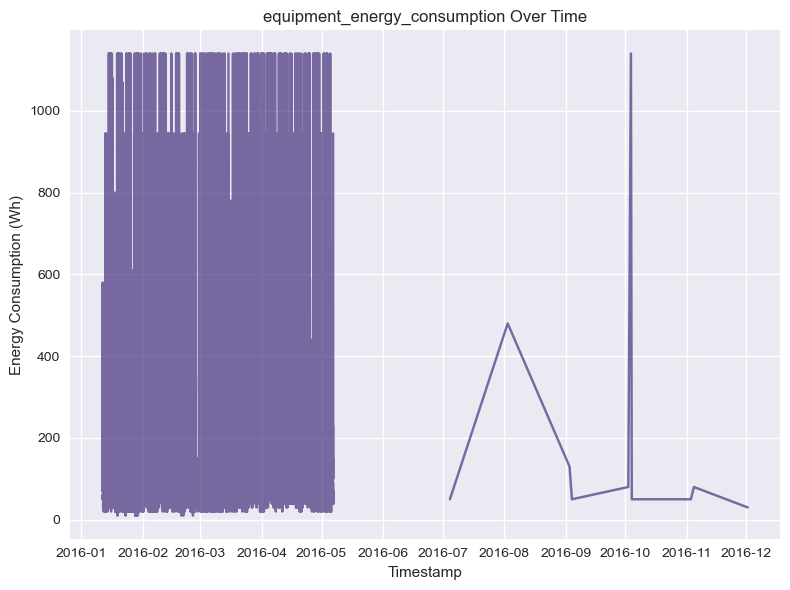

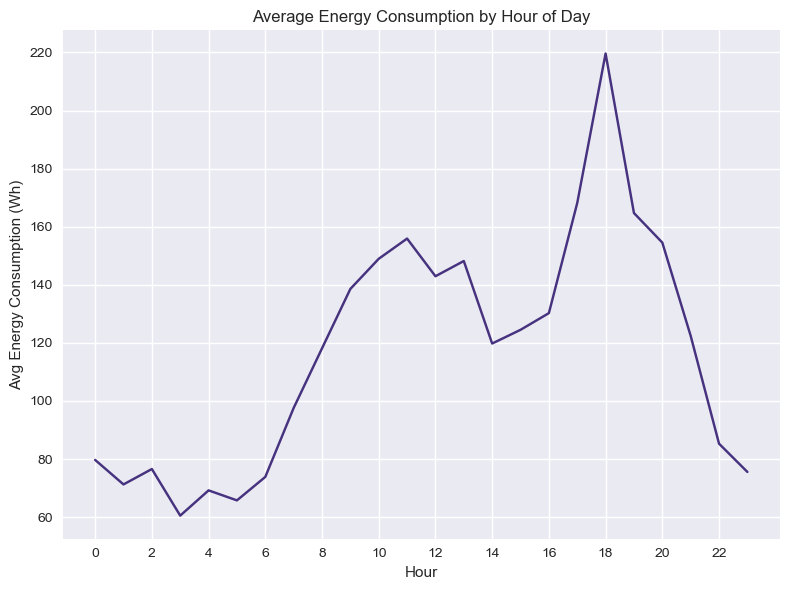

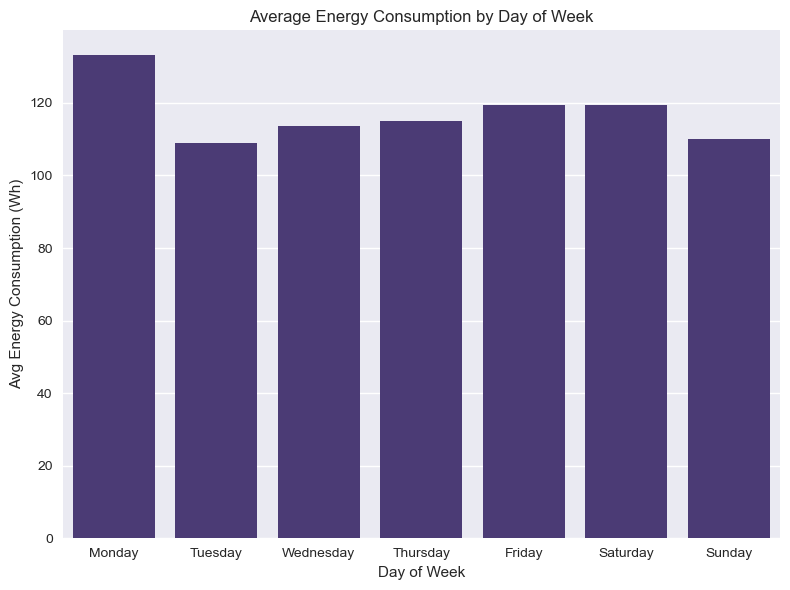

In [299]:
print("\n Target Variable Distribution")
target = 'equipment_energy_consumption'

plt.figure(figsize=(8, 6))
sns.histplot(df[target], kde=True)
plt.title(f'Distribution of {target}')
plt.xlabel('Energy Consumption (Wh)')
plt.ylabel('Frequency')
plt.axvline(df[target].mean(), color='red', linestyle='--', label=f'Mean: {df[target].mean():.2f} Wh')
plt.axvline(df[target].median(), color='green', linestyle='--', label=f'Median: {df[target].median():.2f} Wh')
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

print('-'*50)
# finding skewness and kurtosis
skewness = stats.skew(df[target].dropna())
kurtosis = stats.kurtosis(df[target].dropna())
print(f"\nSkewness: {skewness:.4f}")
print(f"Kurtosis: {kurtosis:.4f}")

print('-'*50)
print("\n Autocorrelation Analysis")
if 'timestamp' in df.columns:
    plt.figure(figsize=(8, 6))
    plot_acf(df[target].dropna(), lags=48)
    plt.title('Autocorrelation of Energy Consumption')
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # Partial autocorrelation
    plt.figure(figsize=(8, 6))
    plot_pacf(df[target].dropna(), lags=48)
    plt.title('Partial Autocorrelation of Energy Consumption')
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # Lag plot
    plt.figure(figsize=(8, 6))
    lag_plot(df[target])
    plt.title('Lag Plot of Energy Consumption')
    plt.tight_layout()
    plt.show()
    plt.close()
    
print("\n  Target Variable Over Time")
# extracting datetime features
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day
df['weekday'] = df['timestamp'].dt.weekday
df['month'] = df['timestamp'].dt.month
df['year'] = df['timestamp'].dt.year
if 'timestamp' in df.columns:
    plt.figure(figsize=(8, 6))
    plt.plot(df['timestamp'], df[target], alpha=0.7)
    plt.title(f'{target} Over Time')
    plt.xlabel('Timestamp')
    plt.ylabel('Energy Consumption (Wh)')
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # daily and weekly patterns
    if df['timestamp'].dt.date.nunique() > 1:
        # Resample by day and hour
        hourly_consumption = df.set_index('timestamp').resample('h')[target].mean()
        daily_consumption = df.set_index('timestamp').resample('D')[target].mean()
        
        # ploting daily pattern (average by hour)
        hour_avg = df.groupby('hour')[target].mean()
        plt.figure(figsize=(8, 6))
        sns.lineplot(x=hour_avg.index, y=hour_avg.values)
        plt.title('Average Energy Consumption by Hour of Day')
        plt.xlabel('Hour')
        plt.ylabel('Avg Energy Consumption (Wh)')
        plt.xticks(range(0, 24, 2))
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        plt.close()
        
        # ploting weekly pattern (average by day of week)
        if df['weekday'].nunique() > 1:
            weekday_avg = df.groupby('weekday')[target].mean()
            days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
            plt.figure(figsize=(8, 6))
            sns.barplot(x=weekday_avg.index, y=weekday_avg.values)
            plt.title('Average Energy Consumption by Day of Week')
            plt.xlabel('Day of Week')
            plt.ylabel('Avg Energy Consumption (Wh)')
            plt.xticks(range(7), days)
            plt.tight_layout()
            plt.show()
            plt.close()

## 5. Feature Anaysis
- Below code represnts the detailed analysis of features and target variables
-  It gives some key insights like there is no Correlation Between Energy Consumption and Zone Conditions
-  Ramdom variable 1 and 2 does not have significant corelation with target variable and it is varified through the scatter plot
-  the peak energy consumption hours is from 8 to 14 and 16 to 20


 FEATURE ANALYSIS
----------------------------------------------------------------------

 Zone Temperature Analysis


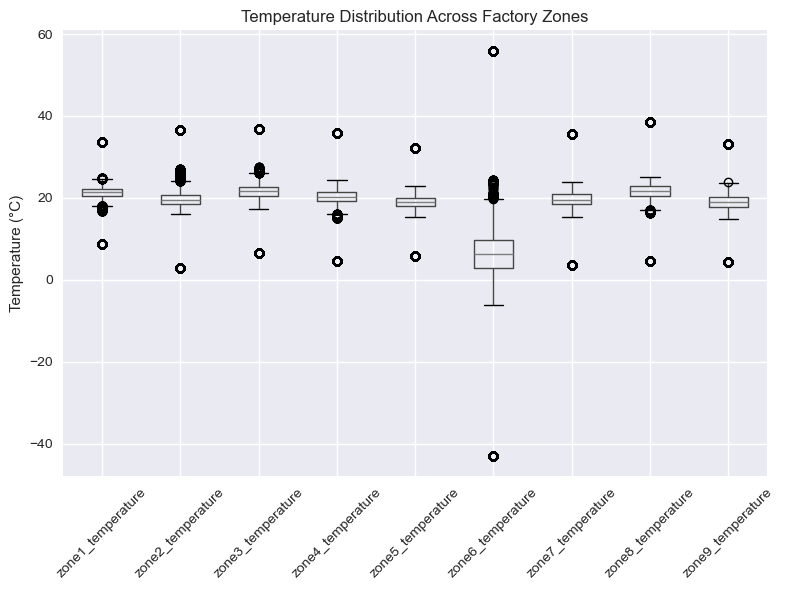


Zone Temperature Statistics:
                         min       mean        max       std
zone1_temperature   8.726818  21.249414  33.746609  2.165618
zone2_temperature   2.988199  19.793113  36.552882  2.943771
zone3_temperature   6.543921  21.665733  36.823982  2.594309
zone4_temperature   4.613485  20.239922  35.921144  2.783050
zone5_temperature   5.921094  19.052613  32.157594  2.346158
zone6_temperature -42.987365   6.469934  55.932271  8.867993
zone7_temperature   3.578021  19.672472  35.712952  2.879815
zone8_temperature   4.502372  21.606344  38.626835  2.974989
zone9_temperature   4.476511  18.851085  33.238012  2.528783


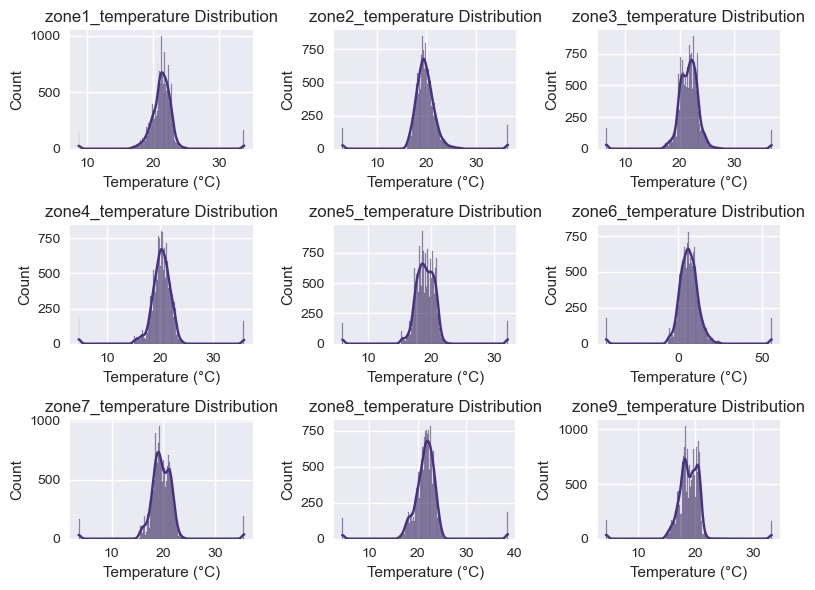


 Zone Humidity Analysis


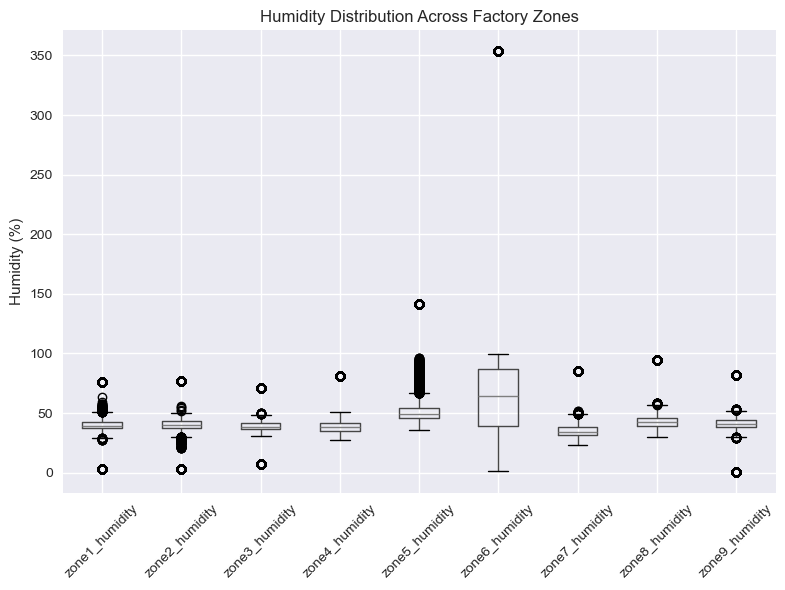


 Zone Humidity Statistics:
                      min       mean         max        std
zone1_humidity   3.348060  39.798402   76.292756   6.303286
zone2_humidity   3.193842  40.217713   77.265503   6.720768
zone3_humidity   6.902515  39.128153   71.406273   5.496414
zone4_humidity  27.660000  39.186727   81.446225   6.232138
zone5_humidity  35.363333  52.128815  141.640143  13.152312
zone6_humidity   1.000000  63.322301  353.393026  42.010139
zone7_humidity  23.200000  35.363608   84.882898   6.923356
zone8_humidity  29.600000  43.223330   94.385668   7.414558
zone9_humidity   0.918228  41.238814   81.582494   7.037234


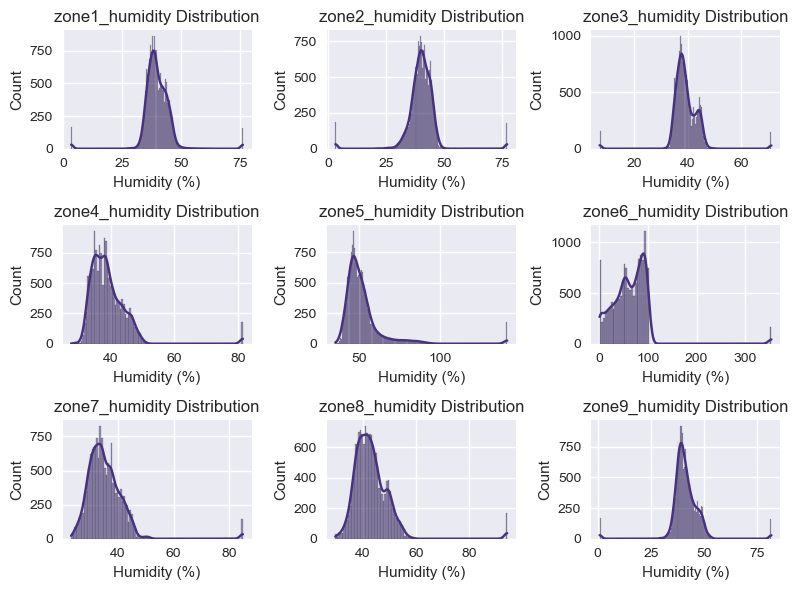


 External Weather Analysis


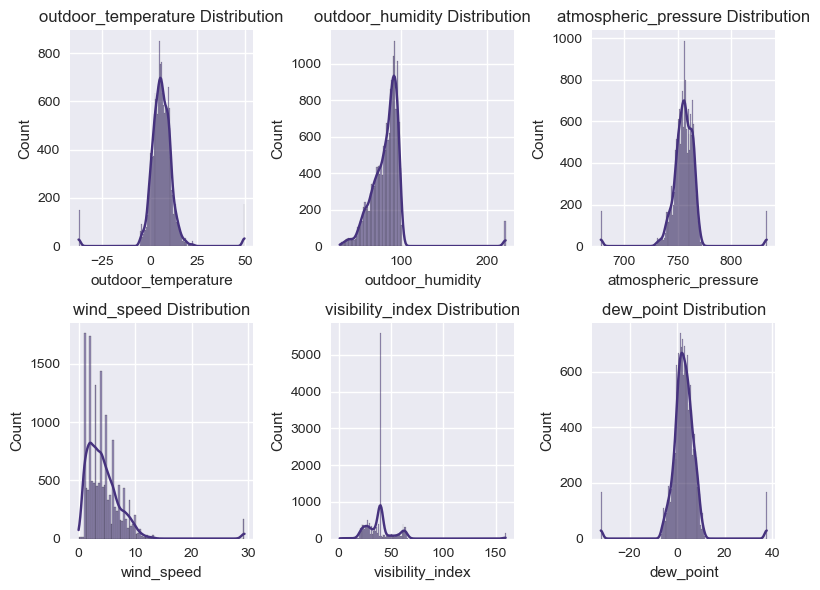

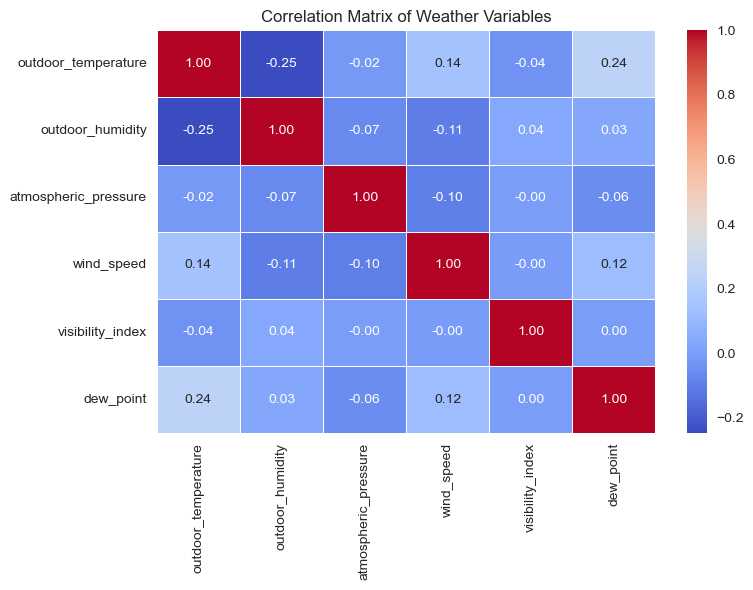

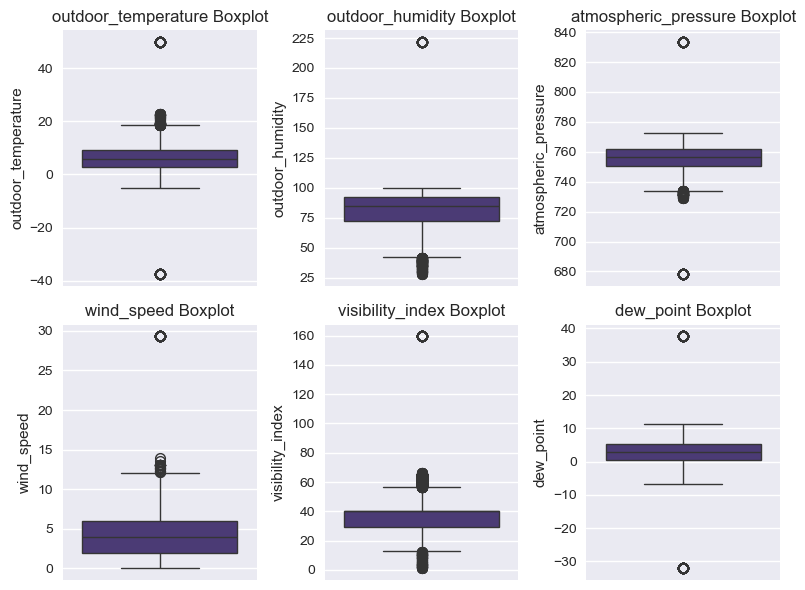


 Weather Variables Statistics:
                             min        mean         max        std
outdoor_temperature   -37.524768    6.218582   49.853906   7.554684
outdoor_humidity       28.000000   81.942775  221.668765  19.201811
atmospheric_pressure  678.159940  755.757602  833.392675  13.643585
wind_speed              0.000000    4.463719   29.318719   3.585240
visibility_index        1.000000   39.843230  159.606156  17.039617
dew_point             -32.098095    2.783507   37.673716   6.094732

 Correlation Between Energy Consumption and Weather
equipment_energy_consumption    1.000000
outdoor_temperature             0.037175
wind_speed                      0.034089
dew_point                       0.014497
visibility_index                0.004700
atmospheric_pressure           -0.014487
outdoor_humidity               -0.063122
Name: equipment_energy_consumption, dtype: float64


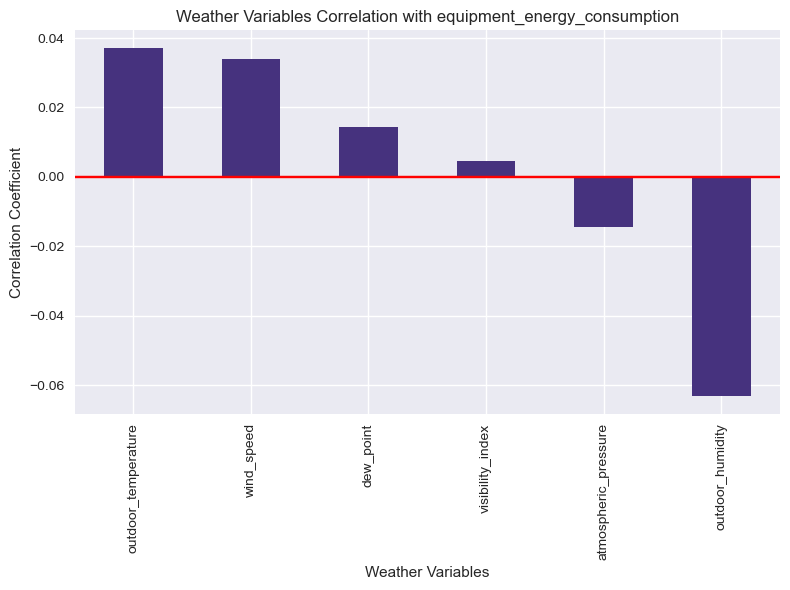


 Correlation Between Energy Consumption and Zone Conditions
equipment_energy_consumption    1.000000
zone2_temperature               0.044028
zone1_temperature               0.033289
zone1_humidity                  0.033236
zone3_temperature               0.031613
zone6_temperature               0.030648
zone4_temperature               0.025302
zone3_humidity                  0.016391
zone9_temperature               0.011642
zone5_humidity                  0.006059
zone4_humidity                  0.005270
zone7_temperature               0.004904
zone8_temperature               0.002452
zone5_temperature               0.002000
zone7_humidity                 -0.012657
zone2_humidity                 -0.019088
zone9_humidity                 -0.022416
zone6_humidity                 -0.034142
zone8_humidity                 -0.053255
Name: equipment_energy_consumption, dtype: float64


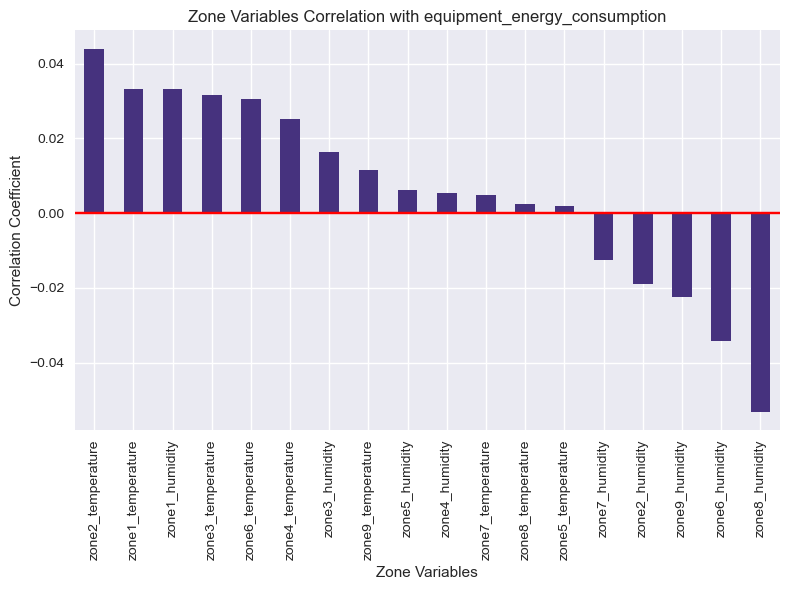


 Random Variables Analysis

Correlation of Random Variables with Target:
random_variable1               -0.008989
random_variable2               -0.006223
equipment_energy_consumption    1.000000
Name: equipment_energy_consumption, dtype: float64


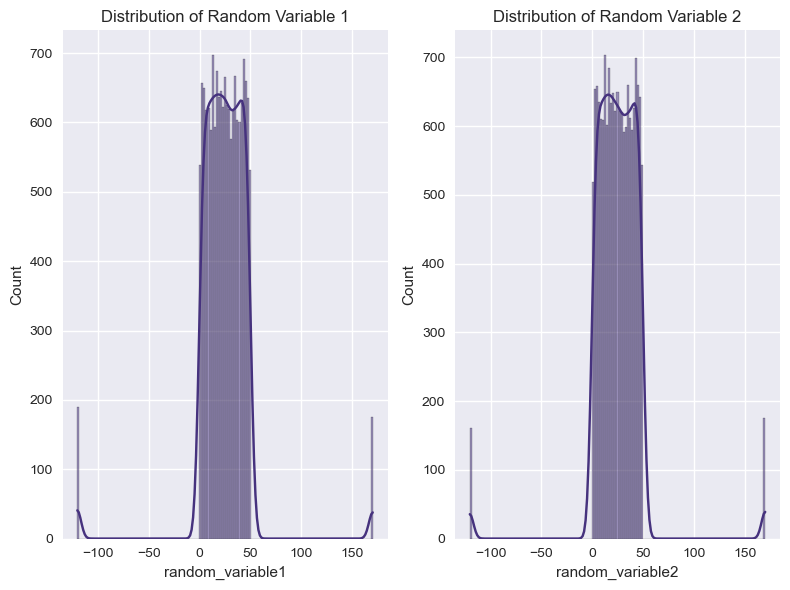

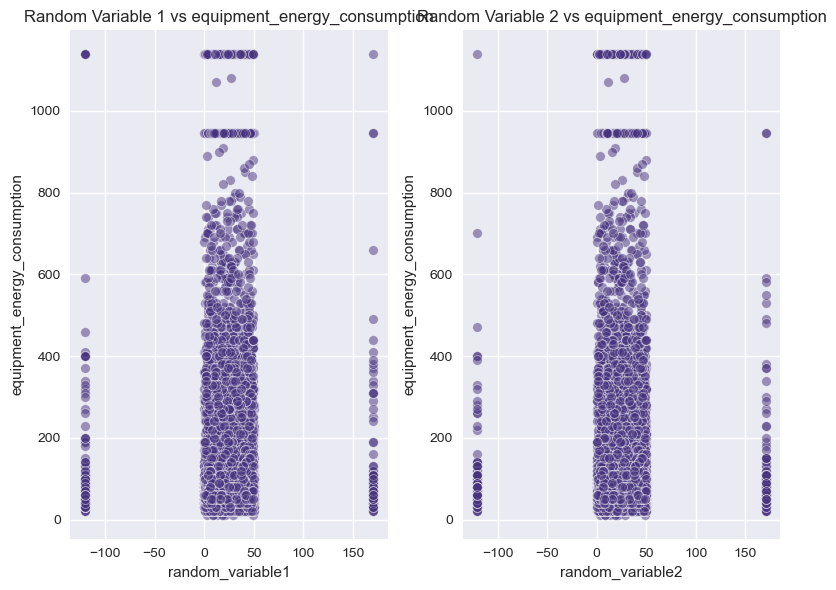


  Lighting Energy Analysis


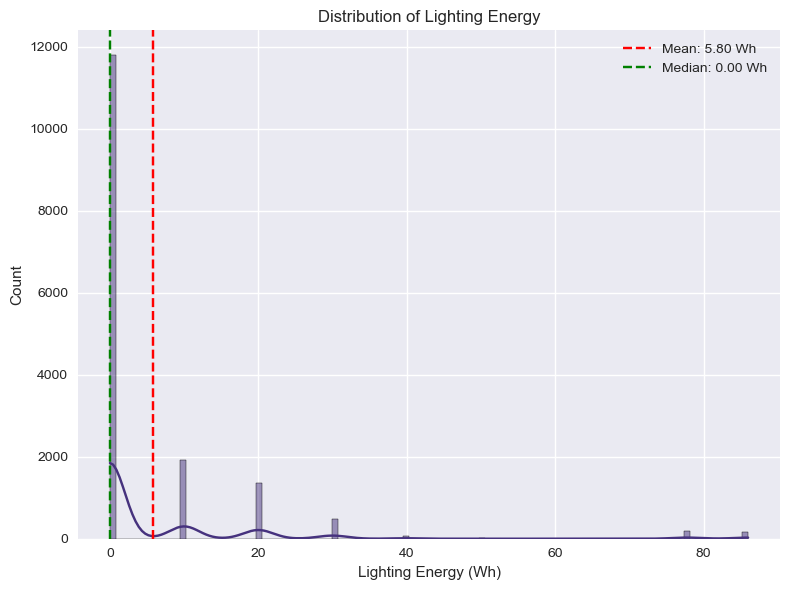


Lighting Energy Statistics:
count    15993.000000
mean         5.797220
std         13.946071
min          0.000000
25%          0.000000
50%          0.000000
75%         10.000000
max         86.002966
Name: lighting_energy, dtype: float64

Correlation between lighting_energy and equipment_energy_consumption: 0.0750


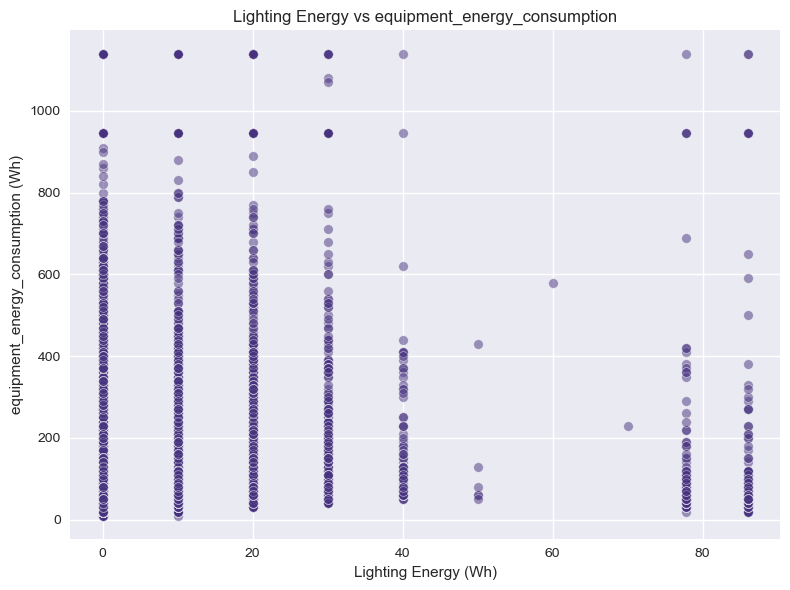

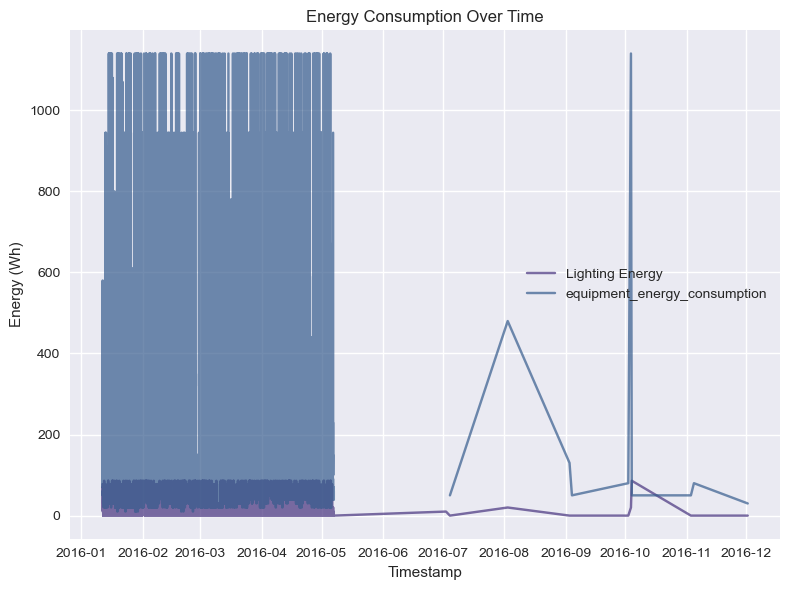

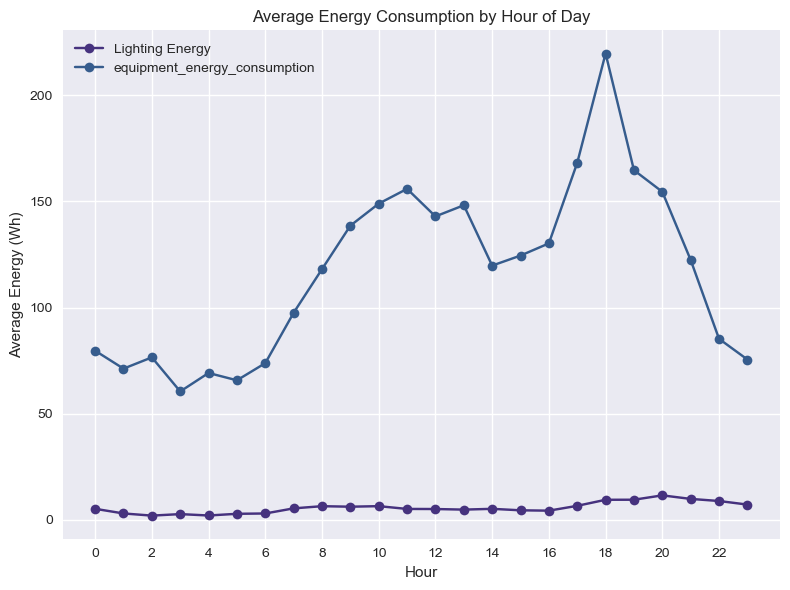

In [303]:
# ----------------------------------------------------------------
#  FEATURE ANALYSIS
# ----------------------------------------------------------------
print("\n FEATURE ANALYSIS")
print("-" * 70)

print("\n Zone Temperature Analysis")

zone_temp_columns = [col for col in df.columns if 'temperature' in col and 'zone' in col]

plt.figure(figsize=(8, 6))
df[zone_temp_columns].boxplot()
plt.title('Temperature Distribution Across Factory Zones')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
#plt.savefig('zone_temperature_boxplot.png')
plt.close()

print("\nZone Temperature Statistics:")
print(df[zone_temp_columns].describe().T[['min', 'mean', 'max', 'std']])

# Histograms for each zone's temperature
plt.figure(figsize=(8, 6))
for i, col in enumerate(zone_temp_columns):
    plt.subplot(3, 3, i+1)
    sns.histplot(df[col], kde=True)
    plt.title(f'{col} Distribution')
    plt.xlabel('Temperature (°C)')
plt.tight_layout()
plt.show()
# plt.savefig('zone_temperature_histograms.png')
plt.close()

print("\n Zone Humidity Analysis")
zone_humidity_columns = [col for col in df.columns if 'humidity' in col and 'zone' in col]

plt.figure(figsize=(8, 6))
df[zone_humidity_columns].boxplot()
plt.title('Humidity Distribution Across Factory Zones')
plt.ylabel('Humidity (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# plt.savefig('zone_humidity_boxplot.png')
plt.close()

print("\n Zone Humidity Statistics:")
print(df[zone_humidity_columns].describe().T[['min', 'mean', 'max', 'std']])

# Histograms for each zone's humidity
plt.figure(figsize=(8, 6))
for i, col in enumerate(zone_humidity_columns):
    plt.subplot(3, 3, i+1)
    sns.histplot(df[col], kde=True)
    plt.title(f'{col} Distribution')
    plt.xlabel('Humidity (%)')
plt.tight_layout()
#plt.savefig('zone_humidity_histograms.png')
plt.show()
plt.close()

print("\n External Weather Analysis")
weather_columns = ['outdoor_temperature', 'outdoor_humidity', 'atmospheric_pressure', 
                  'wind_speed', 'visibility_index', 'dew_point']

# Histograms for weather variables
plt.figure(figsize=(8, 6))
for i, col in enumerate(weather_columns):
    plt.subplot(2, 3, i+1)
    sns.histplot(df[col], kde=True)
    plt.title(f'{col} Distribution')
plt.tight_layout()
# plt.savefig('weather_histograms.png')
plt.show()
plt.close()

# Create correlation matrix for weather variables
weather_corr = df[weather_columns].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(weather_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Weather Variables')
plt.tight_layout()
# plt.savefig('weather_correlation.png')
plt.show()
plt.close()

# Boxplots for weather variables
plt.figure(figsize=(8, 6))
for i, col in enumerate(weather_columns):
    plt.subplot(2, 3, i+1)
    sns.boxplot(y=df[col])
    plt.title(f'{col} Boxplot')
plt.tight_layout()
# plt.savefig('weather_boxplots.png')
plt.show()
plt.close()

print("\n Weather Variables Statistics:")
print(df[weather_columns].describe().T[['min', 'mean', 'max', 'std']])

print("\n Correlation Between Energy Consumption and Weather")
weather_energy_corr = df[weather_columns + [target]].corr()[target].sort_values(ascending=False)
print(weather_energy_corr)

# Bar plot of correlations
plt.figure(figsize=(8, 6))
weather_energy_corr.drop(target).plot(kind='bar')
plt.title(f'Weather Variables Correlation with {target}')
plt.xlabel('Weather Variables')
plt.ylabel('Correlation Coefficient')
plt.axhline(y=0, color='r', linestyle='-')
plt.tight_layout()
# plt.savefig('weather_energy_correlation.png')
plt.show()
plt.close()

print("\n Correlation Between Energy Consumption and Zone Conditions")
zone_columns = zone_temp_columns + zone_humidity_columns
zone_energy_corr = df[zone_columns + [target]].corr()[target].sort_values(ascending=False)
print(zone_energy_corr)

# Bar plot of correlations
plt.figure(figsize=(8, 6))
zone_energy_corr.drop(target).plot(kind='bar')
plt.title(f'Zone Variables Correlation with {target}')
plt.xlabel('Zone Variables')
plt.ylabel('Correlation Coefficient')
plt.axhline(y=0, color='r', linestyle='-')
plt.xticks(rotation=90)
plt.tight_layout()
# plt.savefig('zone_energy_correlation.png')
plt.show()
plt.close()

print("\n Random Variables Analysis")
random_vars = ['random_variable1', 'random_variable2']
if all(var in df.columns for var in random_vars):
    # Correlation with target
    random_corr = df[random_vars + [target]].corr()[target]
    print("\nCorrelation of Random Variables with Target:")
    print(random_corr)
    
    # Visualize distributions
    plt.figure(figsize=(8, 6))
    
    plt.subplot(1, 2, 1)
    sns.histplot(df['random_variable1'], kde=True)
    plt.title('Distribution of Random Variable 1')
    
    plt.subplot(1, 2, 2)
    sns.histplot(df['random_variable2'], kde=True)
    plt.title('Distribution of Random Variable 2')
    
    plt.tight_layout()
    # plt.savefig('random_variables_distribution.png')
    plt.show()
    plt.close()
    
    # Visualize relationship with target
    plt.figure(figsize=(8, 6))
    
    plt.subplot(1, 2, 1)
    sns.scatterplot(x='random_variable1', y=target, data=df, alpha=0.5)
    plt.title(f'Random Variable 1 vs {target}')
    
    plt.subplot(1, 2, 2)
    sns.scatterplot(x='random_variable2', y=target, data=df, alpha=0.5)
    plt.title(f'Random Variable 2 vs {target}')
    
    plt.tight_layout()
    # plt.savefig('random_variables_scatter.png')
    plt.show()
    plt.close()

print("\n  Lighting Energy Analysis")
if 'lighting_energy' in df.columns:
    # Distribution analysis
    plt.figure(figsize=(8, 6))
    sns.histplot(df['lighting_energy'], kde=True)
    plt.title('Distribution of Lighting Energy')
    plt.xlabel('Lighting Energy (Wh)')
    plt.axvline(df['lighting_energy'].mean(), color='red', linestyle='--', 
                label=f'Mean: {df["lighting_energy"].mean():.2f} Wh')
    plt.axvline(df['lighting_energy'].median(), color='green', linestyle='--', 
                label=f'Median: {df["lighting_energy"].median():.2f} Wh')
    plt.legend()
    plt.tight_layout()
    # plt.savefig('lighting_energy_distribution.png')
    plt.show()
    plt.close()
    
    # Statistics
    print("\nLighting Energy Statistics:")
    print(df['lighting_energy'].describe())
    
    # Correlation with equipment energy
    lighting_corr = df[['lighting_energy', target]].corr().iloc[0, 1]
    print(f"\nCorrelation between lighting_energy and {target}: {lighting_corr:.4f}")
    
    # Scatter plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='lighting_energy', y=target, data=df, alpha=0.5)
    plt.title(f'Lighting Energy vs {target}')
    plt.xlabel('Lighting Energy (Wh)')
    plt.ylabel(f'{target} (Wh)')
    plt.tight_layout()
    plt.show()
    # plt.savefig('lighting_energy_scatter.png')
    plt.close()
    
    # Time series comparison
    if 'timestamp' in df.columns:
        plt.figure(figsize=(8, 6))
        plt.plot(df['timestamp'], df['lighting_energy'], label='Lighting Energy', alpha=0.7)
        plt.plot(df['timestamp'], df[target], label=target, alpha=0.7)
        plt.title('Energy Consumption Over Time')
        plt.xlabel('Timestamp')
        plt.ylabel('Energy (Wh)')
        plt.legend()
        plt.tight_layout()
        plt.show()
        # plt.savefig('energy_comparison_time.png')
        plt.close()
        
        # Hourly patterns comparison
        if 'hour' in df.columns:
            plt.figure(figsize=(8, 6))
            hourly_lighting = df.groupby('hour')['lighting_energy'].mean()
            hourly_equipment = df.groupby('hour')[target].mean()
            
            plt.plot(hourly_lighting.index, hourly_lighting.values, 'o-', label='Lighting Energy')
            plt.plot(hourly_equipment.index, hourly_equipment.values, 'o-', label=target)
            plt.title('Average Energy Consumption by Hour of Day')
            plt.xlabel('Hour')
            plt.ylabel('Average Energy (Wh)')
            plt.xticks(range(0, 24, 2))
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
            # plt.savefig('hourly_energy_comparison.png')
            plt.close()


## 6. Outlier Treatment

In [ ]:
df_before_treatment = df.copy()
# Function to handle outliers with proper validation
def handle_outliers(df, column, strategy='winsorize', lower_bound=None, upper_bound=None, 
                          iqr_multiplier=1.5, create_indicator=True):
    """
    Handle outliers for specific columns with proper validation
    
    Parameters:
    -----------
    df : pandas DataFrame
        Input dataset
    column : str
        Column name to process
    strategy : str
        'winsorize', 'cap', 'remove'
    lower_bound, upper_bound : float
        Domain-specific bounds (if strategy='cap')
    iqr_multiplier : float
        Multiplier for IQR method (if strategy='winsorize')
    create_indicator : bool
        Whether to create an outlier indicator column
    
    Returns:
    --------
    df_result : pandas DataFrame
        Processed dataframe
    """
    # Create a deep copy to ensure we don't modify the original
    df_result = df.copy()
    
    # Calculate IQR bounds
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    
    if strategy == 'winsorize':
        # Define bounds based on IQR
        lower = q1 - (iqr_multiplier * iqr)
        upper = q3 + (iqr_multiplier * iqr)
    elif strategy == 'cap':
        # Use provided domain-specific bounds
        lower = lower_bound
        upper = upper_bound
    else:
        # For 'remove' strategy, use IQR bounds
        lower = q1 - (iqr_multiplier * iqr)
        upper = q3 + (iqr_multiplier * iqr)
    
    # Create indicator before modifying values
    if create_indicator:
        df_result[f'{column}_outlier'] = ((df_result[column] < lower) | 
                                         (df_result[column] > upper)).astype(int)
    
    # Apply the chosen strategy
    if strategy == 'winsorize':
        # Explicitly clip values within the bounds
        print(f"Winsorizing {column} with bounds: [{lower:.2f}, {upper:.2f}]")
        df_result[column] = df_result[column].clip(lower=lower, upper=upper)
        
    elif strategy == 'cap':
        print(f"Capping {column} with bounds: [{lower:.2f}, {upper:.2f}]")
        df_result[column] = df_result[column].clip(lower=lower, upper=upper)
        
    elif strategy == 'remove':
        print(f"Removing outliers from {column} with bounds: [{lower:.2f}, {upper:.2f}]")
        df_result = df_result[(df_result[column] >= lower) & (df_result[column] <= upper)]
    return df_result



# 1. Target variable: use conservative winsorization to preserve legitimate patterns
data = handle_outliers(df, 'equipment_energy_consumption', 
                      strategy='winsorize', 
                      iqr_multiplier=3,
                      create_indicator=True)

# 2. Environmental variables: (I am assuming that the temp is b/w -5 to 50, i am guessing it based on the data i have seen)
# Temperature for typical factory environments 
for zone in range(1, 7):
    data = handle_outliers(data, f'zone{zone}_temperature', 
                          strategy='cap', 
                          lower_bound=-5.0, 
                          upper_bound=50.0,  
                          create_indicator=True)

# Humidity has natural physical bounds
for zone in range(1, 7):
    data = handle_outliers(data, f'zone{zone}_humidity', 
                          strategy='cap', 
                          lower_bound=0.0,    
                          upper_bound=100.0, 
                          create_indicator=True)

# 3. Visibility index: 
data = handle_outliers(data, 'visibility_index', 
                      strategy='winsorize',
                      iqr_multiplier=2.0,
                      create_indicator=True)

# 4. Atmospheric pressure: (i am assuming these values based on the data)
data = handle_outliers(data, 'atmospheric_pressure', 
                      strategy='cap',
                      lower_bound=870.0,  
                      upper_bound=1085.0, 
                      create_indicator=True)

In [315]:
# function to validate our outlier treatment
def validate_outlier_treatment(original_df, treated_df, column):
    """
    Visualize the effect of outlier treatment on a specific column
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # original data distribution
    ax1.hist(original_df[column], bins=50, alpha=0.7)
    ax1.set_title(f'Original {column} Distribution')
    ax1.set_xlabel(column)
    ax1.set_ylabel('Frequency')
    
    # treated data distribution
    ax2.hist(treated_df[column], bins=50, alpha=0.7)
    ax2.set_title(f'Treated {column} Distribution')
    ax2.set_xlabel(column)
    
    plt.tight_layout()
    plt.show()
    
    # print summary statistics
    print(f"Original {column}: Mean={original_df[column].mean():.2f}, STD={original_df[column].std():.2f}")
    print(f"Treated {column}: Mean={treated_df[column].mean():.2f}, STD={treated_df[column].std():.2f}")
    
    # check if the function  actually reduced outliers
    q1, q3 = original_df[column].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower = q1 - (1.5 * iqr)
    upper = q3 + (1.5 * iqr)
    
    original_outliers = ((original_df[column] < lower) | (original_df[column] > upper)).sum()
    treated_outliers = ((treated_df[column] < lower) | (treated_df[column] > upper)).sum()
    

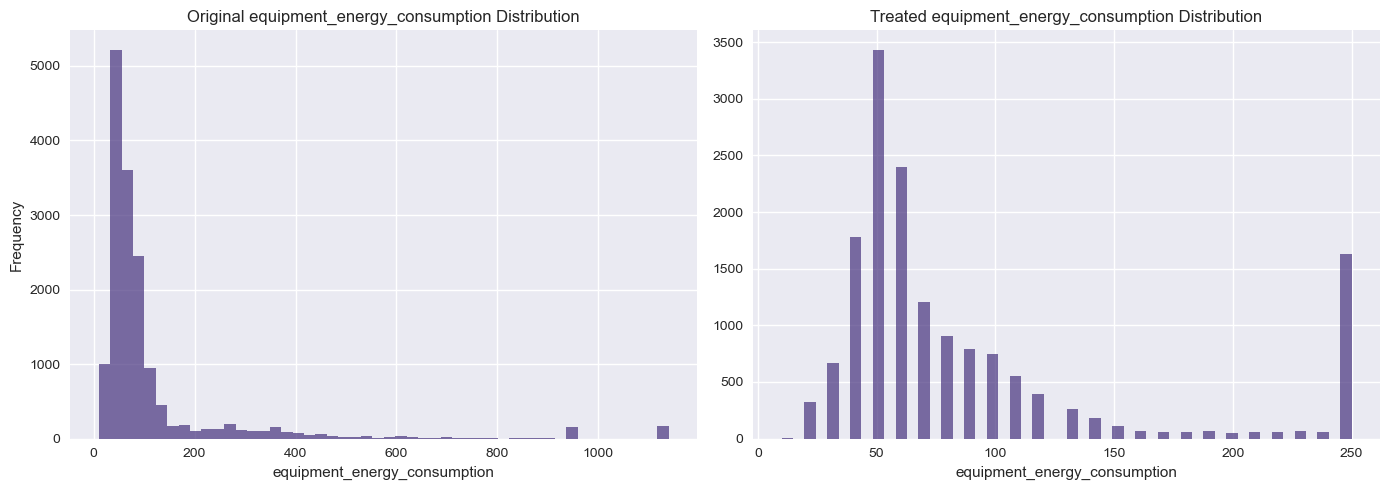

Original equipment_energy_consumption: Mean=117.08, STD=169.91
Treated equipment_energy_consumption: Mean=88.91, STD=64.98


In [317]:
validate_outlier_treatment(df_before_treatment, data, 'equipment_energy_consumption')

In [192]:
data[['random_variable1', 'random_variable2', 'equipment_energy_consumption']].corr()

,random_variable1,random_variable2,equipment_energy_consumption
random_variable1,1.000000,0.297530,-0.007336
random_variable2,0.297530,1.000000,-0.005641
equipment_energy_consumption,-0.007336,-0.005641,1.000000


## 7. Handling Misssing value 

In [320]:
# since we have timestamp column so we apply forward fill then backward fill for zone temperatures and humidities
for zone in range(1, 10):
    temp_col = f'zone{zone}_temperature'
    hum_col = f'zone{zone}_humidity'
    if temp_col in data.columns:
        data[temp_col] = data[temp_col].ffill().bfill()
    if hum_col in data.columns:
        data[hum_col] = data[hum_col].ffill().bfill()

# List of other numeric features
num_cols = [
    'lighting_energy',
    'atmospheric_pressure',
    'wind_speed',
    'dew_point',
    'visibility_index'
]

for col in num_cols:
    data[col] = data[col].median()

# Apply time-aware fill
for col in ['outdoor_temperature','outdoor_humidity']:
    data[col] = data[col].ffill().bfill()


In [324]:
# removing unneccessary column
unneccessary_cols = [
    'random_variable1',
    'random_variable2',
    'equipment_energy_consumption_outlier',
    'zone1_temperature_outlier',
    'zone2_temperature_outlier',
    'zone3_temperature_outlier',
    'zone4_temperature_outlier',
    'zone5_temperature_outlier',
    'zone6_temperature_outlier',
    'zone1_humidity_outlier',
    'zone2_humidity_outlier',
    'zone3_humidity_outlier',
    'zone4_humidity_outlier',
    'zone5_humidity_outlier',
    'zone6_humidity_outlier',
    'visibility_index_outlier',
    'atmospheric_pressure_outlier'
]

final_df = data.drop(columns=unneccessary_cols)
final_df.shape

(16857, 32)

In [326]:
final_df.sample(2)

,timestamp,equipment_energy_consumption,lighting_energy,zone1_temperature,zone1_humidity,zone2_temperature,zone2_humidity,zone3_temperature,zone3_humidity,zone4_temperature,zone4_humidity,zone5_temperature,zone5_humidity,zone6_temperature,zone6_humidity,zone7_temperature,zone7_humidity,zone8_temperature,zone8_humidity,zone9_temperature,zone9_humidity,outdoor_temperature,atmospheric_pressure,outdoor_humidity,wind_speed,visibility_index,dew_point,hour,day,weekday,month,year
6311,2016-02-24 09:10:00,90.0,0.0,20.133333,39.163333,18.0,40.56,36.823982,38.845,19.50,36.466667,18.463333,51.166667,-1.133333,83.466667,18.657143,35.982857,19.823333,42.723333,18.157143,40.491429,-0.233333,870.0,98.666667,4.0,40.0,2.75,9,24,2,2,2016
1242,2016-01-20 07:10:00,NaN,0.0,18.426667,39.463333,17.0,40.03,18.700000,38.900,17.29,38.500000,16.873333,48.852778,-3.400000,90.634444,16.790000,31.449444,18.957222,44.202222,16.290000,41.766667,-2.733333,870.0,89.333333,4.0,40.0,2.75,7,20,2,1,2016


## Key Insights and summary

In [344]:
# ----------------------------------------------------------------
# 8. KEY INSIGHTS AND SUMMARY
# ----------------------------------------------------------------
print("\n KEY INSIGHTS AND SUMMARY")
print("-" * 70)

print("\n Target Variable Summary")
print(f"Mean energy consumption: {final_df[target].mean():.2f} Wh")
print(f"Median energy consumption: {final_df[target].median():.2f} Wh")
print(f"Minimum energy consumption: {final_df[target].min():.2f} Wh")
print(f"Maximum energy consumption: {final_df[target].max():.2f} Wh")
print(f"Standard deviation: {final_df[target].std():.2f} Wh")

print("\n Zone Analysis")
corr_matrix = final_df.select_dtypes(include=np.number).corr()
# Calculate average temperature and humidity by zone
zone_summary = []
for i in range(1, 10):
    temp_col = f'zone{i}_temperature'
    humid_col = f'zone{i}_humidity'
    avg_temp = final_df[temp_col].mean()
    avg_humid = final_df[humid_col].mean()
    temp_corr = corr_matrix.loc[temp_col, target]
    humid_corr = corr_matrix.loc[humid_col, target]
    zone_summary.append({
        'Zone': i,
        'Avg Temperature': avg_temp,
        'Avg Humidity': avg_humid,
        'Temp Correlation': temp_corr,
        'Humidity Correlation': humid_corr
    })

zone_df = pd.DataFrame(zone_summary)
print("\nZone Summary:")
print(zone_df)

print("\n Time Pattern Summary")
if 'hour' in df.columns:
    peak_hour = final_df.groupby('hour')[target].mean().idxmax()
    min_hour = final_df.groupby('hour')[target].mean().idxmin()
    print(f"Peak consumption hour: {peak_hour}:00")
    print(f"Minimum consumption hour: {min_hour}:00")

if 'weekday' in final_df.columns and final_df['weekday'].nunique() > 1:
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    peak_day = final_df.groupby('weekday')[target].mean().idxmax()
    min_day = final_df.groupby('weekday')[target].mean().idxmin()
    print(f"Peak consumption day: {days[peak_day]}")
    print(f"Minimum consumption day: {days[min_day]}")

if 'month' in final_df.columns and final_df['month'].nunique() > 1:
    months = ['January', 'February', 'March', 'April', 'May', 'June', 
              'July', 'August', 'September', 'October', 'November', 'December']
    peak_month = final_df.groupby('month')[target].mean().idxmax()
    min_month = final_df.groupby('month')[target].mean().idxmin()
    print(f"Peak consumption month: {months[peak_month-1]}")
    print(f"Minimum consumption month: {months[min_month-1]}")

if 'season' in final_df.columns and final_df['season'].nunique() > 1:
    peak_season = final_df.groupby('season')[target].mean().idxmax()
    min_season = final_df.groupby('season')[target].mean().idxmin()
    print(f"Peak consumption season: {peak_season}")
    print(f"Minimum consumption season: {min_season}")


 KEY INSIGHTS AND SUMMARY
----------------------------------------------------------------------

 Target Variable Summary
Mean energy consumption: 88.91 Wh
Median energy consumption: 60.00 Wh
Minimum energy consumption: 10.00 Wh
Maximum energy consumption: 250.00 Wh
Standard deviation: 64.98 Wh

 Zone Analysis

Zone Summary:
   Zone  Avg Temperature  Avg Humidity  Temp Correlation  Humidity Correlation
0     1        21.249686     39.806960          0.069064              0.051839
1     2        19.790799     40.223778          0.093831             -0.037858
2     3        21.672071     39.119798          0.081937              0.019621
3     4        20.233135     39.185256          0.052597              0.002863
4     5        19.052357     51.651327          0.029955              0.015047
5     6         6.832145     60.597555          0.098802             -0.104845
6     7        19.668852     35.336293          0.026818             -0.058971
7     8        21.606477     43.233213 

## Feature Engineering

#### 1. Indoor-Outdoor Temperature Difference
#### 2. Time-based Categorical Features
- is_weekend
- is_business_hours
- season_winter, season_spring, season_summer, season_fall
#### 3. Rolling Averages of Energy Consumption
- equipment_energy_24h_avg
- lighting_energy_24h_avg
#### 4. Zone Temperature and Humidity Averages
- avg_zone_temperature
- avg_zone_humidity

In [ ]:
# 1. Feature Engineering: Creating a new dataframe with original and engineered features
def engineer_features(df):
    """
    creating 4 feature engineering techniques to the dataset
    """
    # creating a copy of the dataframe to avoid modifying the original
    df_engineered = df.copy()
    
    # Convert timestamp to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(df_engineered['timestamp']):
        df_engineered['timestamp'] = pd.to_datetime(df_engineered['timestamp'])
    
    # Set timestamp as index (useful for time series operations)
    df_engineered = df_engineered.set_index('timestamp')
    
    # 1. Indoor-Outdoor Temperature Difference for each zone
    print("Creating indoor-outdoor temperature differences...")
    for i in range(1, 10):
        df_engineered[f'zone{i}_temp_diff'] = df_engineered[f'zone{i}_temperature'] - df_engineered['outdoor_temperature']
    
    # 2. Time-based Categorical Features
    print("Creating time-based categorical features...")
    # Weekend/Weekday indicator (0 for weekday, 1 for weekend)
    df_engineered['is_weekend'] = df_engineered.index.weekday.isin([5, 6]).astype(int)
    
    # Business hours indicator (8 AM to 6 PM = 1, otherwise 0)
    df_engineered['is_business_hours'] = ((df_engineered.index.hour >= 8) & 
                                          (df_engineered.index.hour < 18)).astype(int)
    
    # Season indicator
    # Define a function to determine season from month
    def get_season(month):
        if month in [12, 1, 2]:
            return 'winter'
        elif month in [3, 4, 5]:
            return 'spring'
        elif month in [6, 7, 8]:
            return 'summer'
        else:
            return 'fall'
    
    df_engineered['season'] = df_engineered.index.month.map(get_season)
    
    # converting season to one-hot encoding
    season_dummies = pd.get_dummies(df_engineered['season'], prefix='season')
    df_engineered = pd.concat([df_engineered, season_dummies], axis=1)
    
    # 3. Rolling Averages of Energy Consumption
    print("Calculating rolling averages...")
    # 24-hour rolling average for equipment energy
    df_engineered['equipment_energy_24h_avg'] = df_engineered['equipment_energy_consumption'].rolling(window=24).mean()
    
    # 24-hour rolling average for lighting energy
    df_engineered['lighting_energy_24h_avg'] = df_engineered['lighting_energy'].rolling(window=24).mean()
    
    # 4. Zone Temperature and Humidity Averages
    print("Computing zone averages...")
    # Calculate average temperature across all zones
    temp_columns = [f'zone{i}_temperature' for i in range(1, 10)]
    df_engineered['avg_zone_temperature'] = df_engineered[temp_columns].mean(axis=1)
    
    # Calculate average humidity across all zones
    humidity_columns = [f'zone{i}_humidity' for i in range(1, 10)]
    df_engineered['avg_zone_humidity'] = df_engineered[humidity_columns].mean(axis=1)
    
    # Handle missing values created by rolling windows
    df_engineered = df_engineered.fillna(method='bfill')
    
    # Reset index to get timestamp back as a column
    df_engineered = df_engineered.reset_index()

    # Lag features
    for lag in [1, 2, 3, 24]:  
        df_engineered[f'energy_lag_{lag}'] = df_engineered['equipment_energy_consumption'].shift(lag)
    
    # Rolling statistics
    df_engineered['energy_rolling_3h_mean'] = df_engineered['equipment_energy_consumption'].rolling(3).mean()
    df_engineered['energy_rolling_24h_std'] = df_engineered['equipment_energy_consumption'].rolling(24).std()
    
    # Zone interactions
    df_engineered['production_heat_index'] = 0.5 * (df['zone1_temperature'] + df_engineered['zone1_humidity'])
    df_engineered['storage_temp_gradient'] = df_engineered['zone5_temperature'] - df_engineered['zone6_temperature']
    
    return df_engineered.dropna()


df_engineered = engineer_features(final_df)


In [ ]:
df_engineered.to_csv('D:\DS-Intern-Assignment\data\model_trainining_data.csv')